# News Mood
This Python script performs a sentiment analysis using Vader of the Twitter activity of selected news oulets: *BBC*, *CBS*, *CNN*, *Fox*, and *New York times*.
- The script collects a sample of tweets, and the sentiment scores will vary depending on the time of day, or the day the script runs. 
- On the sample collected, the overall trend for most news outlet tweets are messages of average sentiments score with more negative weight.

In [1]:
# Dependencies
import tweepy
import numpy as np
import config
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token, config.access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Setup Vader Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

today = datetime.now()
today

datetime.datetime(2018, 3, 26, 12, 59, 51, 27954)

In [2]:
# define function for date manupulation
def seconds_ago(stringdate):
    dtime = datetime.strptime(stringdate,"%a %b %d %H:%M:%S %z %Y")
    dtime = dtime.replace(tzinfo=None)
    dtime = today - dtime    
    return dtime.seconds

#define function for filtering tweets
def human_tweet(tweet):
    # "Real Person" Filters
    min_tweets = 5
    max_tweets = 10000
    max_followers = 2500
    max_following = 2500
    lang = "en"

    if (tweet["followers_count"] < max_followers and
        tweet["statuses_count"] > min_tweets and
        tweet["statuses_count"] < max_tweets and
        tweet["friends_count"] < max_following and
        tweet["lang"] == lang):
        return True
    else:
        return False

# define function for collecting tweets
def collect_tweets(target_news,outcsv):
    sentiments =[]
    for search_term in target_news:
        oldest_tweet = ""
        print(f"Collecting tweets for {search_term}...")                   
        for x in range(5): 
            public_tweets = api.search(
                            search_term,
                            count=20,
                            result_type="recent",
                            max_id=oldest_tweet)
            for tweet in public_tweets["statuses"]:
                if human_tweet(tweet['user']):
                    target_string = tweet['text']
                    vader_scores = analyzer.polarity_scores(target_string)
                    tweet_analysis = {'news_outlet':search_term,
                                       'date':tweet['created_at'],
                                       'compound':vader_scores["compound"],
                                       'positive':vader_scores["pos"],
                                       'negative':vader_scores["neg"],
                                       'neutral':vader_scores["neu"],
                                       'tweet':target_string}
                    sentiments.append(tweet_analysis)
                oldest_tweet = tweet['id']
    # Aggregate into a dataframe the data collected
    sentiment_df = pd.DataFrame(sentiments) 

    # Update date and sort
    sentiment_df['seconds ago'] = sentiment_df['date'].map(seconds_ago)
    sentiment_df = sentiment_df.sort_values("seconds ago")
    sentiment_df.to_csv(outcsv+".csv",index=False)
    print(f"... collected {len(sentiment_df)} total tweets")
    display(sentiment_df.head())
    
#define function for plotting     
def create_plots(filename):
    with open(filename+".csv") as sentimentfile:
        sentiment_df = pd.read_csv(sentimentfile, delimiter=',')        
        psd = sentiment_df.reset_index()
        sns.lmplot(x="index", y="compound", hue="news_outlet",data=psd, size=9, fit_reg=False)        
        title = "Sentiment Analysis of Media Tweets " + today.strftime("%a %b %d %Y")
        plt.title(title)
        plt.ylabel("Tweets polarity")
        plt.xlabel("Tweets ago")
        plt.xlim(len(psd),0) # inverse the x- axis to show decrease over time

        # Save the figure1
        plt.savefig(filename+"_sentiment.png")
        plt.show()

        averages = sentiment_df.groupby("news_outlet")["compound"].mean()
        x_values = np.arange(len(averages))
        sns.barplot(x_values, averages)
        plt.xticks(x_values, target_news)
        title = "Overall Media Sentiment based on Tweeter on " + today.strftime("%a %b %d %Y")
        plt.title(title)
        plt.ylabel("Tweets polarity")
        for a in x_values:
            plt.annotate(
                        '{:,.2f}'.format(averages[a]),  # Use values formated as label
                        (a, averages[a]/2),              # Place label at center of the bar
                        ha='center')                     # align to center

        # Save the figure2
        plt.savefig(filename+"_overall.png")
        plt.legend(loc='best')
        plt.show()    


In [3]:
target_news = ('@BBCWorld','@CBSNews', '@CNN', '@FoxNews', '@nytimes')
tweet_data_file = "output/tweet_data_media"

In [4]:
collect_tweets(target_news,tweet_data_file)

... collected 212 total tweets


,compound,date,negative,neutral,news_outlet,positive,tweet,seconds ago
126,0.4585,Mon Mar 26 19:59:38 +0000 2018,0.000,0.850,@FoxNews,0.150,"RT @ainsleyearhardt: .@dbongino: ""Trying to di...",61213
178,0.0000,Mon Mar 26 19:59:38 +0000 2018,0.000,1.000,@nytimes,0.000,RT @nytimes: Louis Vuitton Names Virgil Abloh ...,61213
127,0.4215,Mon Mar 26 19:59:37 +0000 2018,0.090,0.752,@FoxNews,0.158,"RT @FoxNews: .@charliekirk11: ""They're using a...",61214
128,-0.4003,Mon Mar 26 19:59:37 +0000 2018,0.155,0.757,@FoxNews,0.088,@MissTygrr @FoxNews Yeah old bag. Look at your...,61214
129,-0.6908,Mon Mar 26 19:59:37 +0000 2018,0.825,0.175,@FoxNews,0.000,@FoxNews terrorist,61214


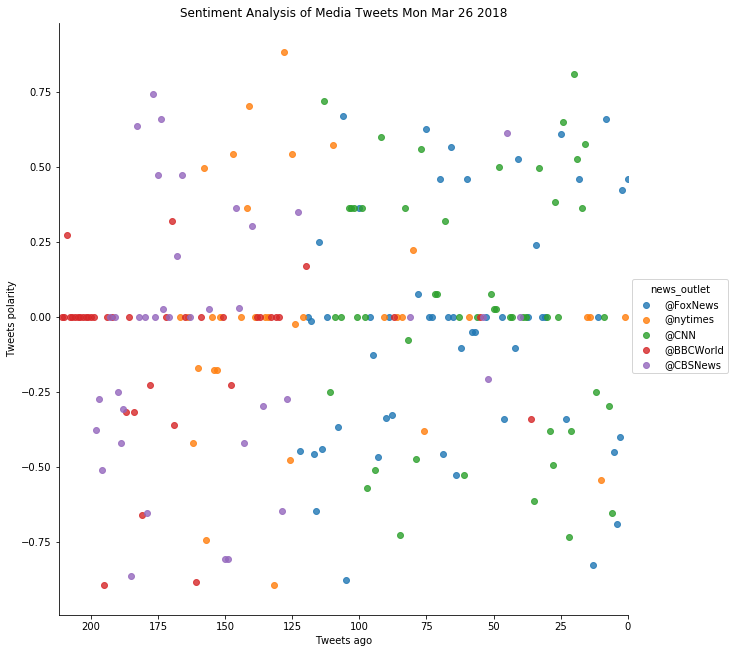

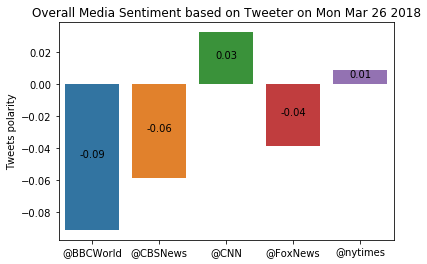

In [5]:
create_plots(tweet_data_file)